# Challenge: High Accuracy Classification For Food-101



Final Prediction Accuracy = 96.16%<br>


In [6]:
import os
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision
from torchvision import models
from sklearn.utils import shuffle
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchinfo


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Understanding the dataset

In [8]:
print("Inpute Files Directory")
print(os.listdir('./food-101/food-101'))

print("\nMeta Files Directory")
print(os.listdir('./food-101/food-101/meta'))

Inpute Files Directory

['.DS_Store', 'README.txt', 'images', 'license_agreement.txt', 'meta']



Meta Files Directory

['classes.txt', 'labels.txt', 'test.json', 'test.txt', 'train.json', 'train.txt']


## Classes

There exists 101 classes in the dataset, however due to the requirements of the project the classes are truncated to only 20 classes listed in the project description

In [9]:
classes = open("./food-101/food-101/meta/classes.txt", 'r').read().splitlines()
classes_21 = classes[:20] + ['other']
classes_21, len(classes_21)

(['apple_pie',
  'baby_back_ribs',
  'baklava',
  'beef_carpaccio',
  'beef_tartare',
  'beet_salad',
  'beignets',
  'bibimbap',
  'bread_pudding',
  'breakfast_burrito',
  'bruschetta',
  'caesar_salad',
  'cannoli',
  'caprese_salad',
  'carrot_cake',
  'ceviche',
  'cheesecake',
  'cheese_plate',
  'chicken_curry',
  'chicken_quesadilla',
  'other'],
 21)

## Identifying testing and training images

The testing and training images are all in the ../input/food-101/food-101/food-101/images/ folder, identifying the test and the training images is done by reading the test.txt and train.txt files in the meta folder

In [10]:
print("Testing images")
with open("./food-101/food-101/meta/test.txt") as f:
    temp = f.read().splitlines()
    for i in range(5):
        print(f"\t{temp[i]}")

print("\nTraining images")
with open("./food-101/food-101/meta/train.txt") as f:
    temp = f.read().splitlines()
    for i in range(5):
        print(f"\t{temp[i]}")

Testing images

	apple_pie/1011328

	apple_pie/101251

	apple_pie/1034399

	apple_pie/103801

	apple_pie/1038694



Training images

	apple_pie/1005649

	apple_pie/1014775

	apple_pie/1026328

	apple_pie/1028787

	apple_pie/1043283


# Exploratory Data Analysis (for dummies)

## Creation of a Dataframe that contains information about the dataset

In [11]:
class Label_encoder:
    def __init__(self, labels):
        self.labels = {label: idx for idx, label in enumerate(labels)}

    def get_label(self, idx):
        return list(self.labels.keys())[idx]

    def get_idx(self, label):
        return self.labels.get(label)

encoder_21 = Label_encoder(classes_21)
encoder_21.get_label(0), encoder_21.get_idx( encoder_21.get_label(0) )

for i in range(21):
    print(encoder_21.get_label(i), encoder_21.get_idx( encoder_21.get_label(i) ))

apple_pie 0

baby_back_ribs 1

baklava 2

beef_carpaccio 3

beef_tartare 4

beet_salad 5

beignets 6

bibimbap 7

bread_pudding 8

breakfast_burrito 9

bruschetta 10

caesar_salad 11

cannoli 12

caprese_salad 13

carrot_cake 14

ceviche 15

cheesecake 16

cheese_plate 17

chicken_curry 18

chicken_quesadilla 19

other 20


In [12]:
def prep_df(path: str) -> pd.DataFrame:
    array = open(path, 'r').read().splitlines()

    # Getting the full path for the images
    img_path = "./food-101/food-101/images/"
    full_path = [img_path + img + ".jpg" for img in array]

    # Splitting the image index from the label
    imgs = []
    for img in array:
        img = img.split('/')

        imgs.append(img)

    imgs = np.array(imgs)

    for idx, img in enumerate(imgs):
        if encoder_21.get_idx(img[0]) is None:
            imgs[idx, 0] = "other"
    
    # Converting the array to a data frame
    imgs = pd.DataFrame(imgs[:, 0], imgs[:,1], columns=['label'])
            
    # Adding the full path to the data frame
    imgs['path'] = full_path

    # Randomly shuffling the order of the data in the dataframe
    imgs = shuffle(imgs)

    return imgs

In [13]:
train_imgs = prep_df('./food-101/food-101/meta/train.txt')
test_imgs = prep_df('./food-101/food-101/meta/test.txt')

train_imgs.groupby(["label"]).count()

,path
label,
apple_pie,750
baby_back_ribs,750
baklava,750
beef_carpaccio,750
beef_tartare,750
beet_salad,750
beignets,750
bibimbap,750
bread_pudding,750



From the randomly sampled images below it could be noticed that due to the formulation of the problem there is a class imbalance towards the "other" class which ends at the character "C" alphabetically

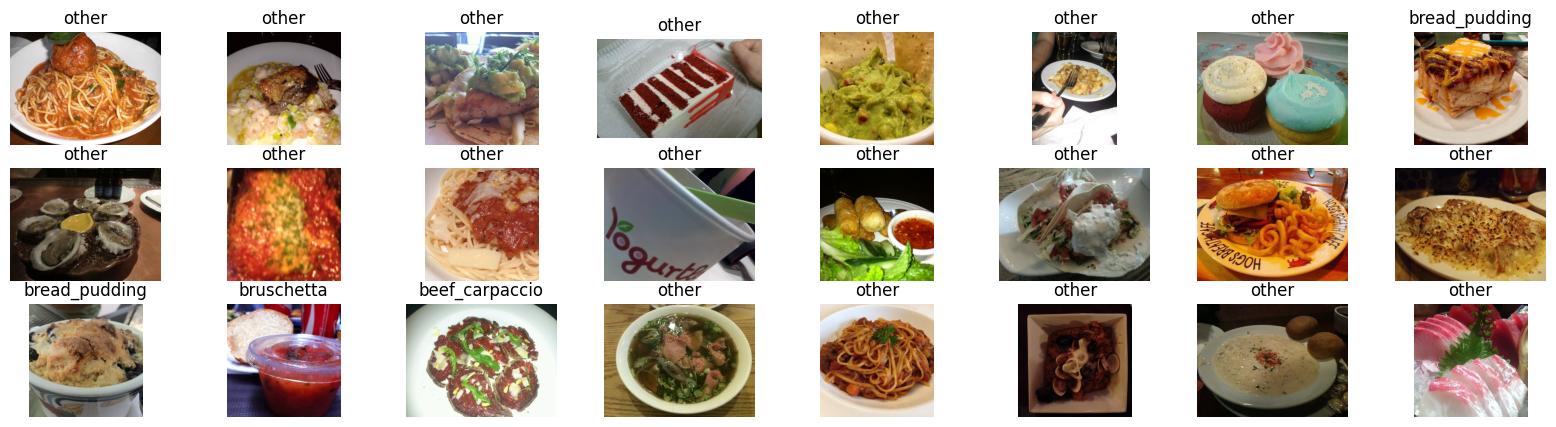

In [14]:
plt.figure(figsize=(20, 5))

num_rows = 3
num_cols = 8


for idx in range(num_rows * num_cols):
    random_idx = np.random.randint(0, train_imgs.shape[0])
    img = plt.imread(train_imgs.path.iloc[random_idx])

    label = train_imgs.label.iloc[random_idx]

    ax = plt.subplot(num_rows, num_cols, idx + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis("off")

## Visualization using a barplot
As can be seen when visualizing through using a barplot, only one class dominates the data with 80%, potentially creating issues during the training where if classifying everything as the outlier will yield a 80% accuracy.

In [15]:
def barplot_vis(imgs_dataframe):# Use the newly integrated Roboto font family for all text.
    fig, ax = plt.subplots()

    new_labels = [row if row in classes_21 else "other" for row in imgs_dataframe.label]
    tmp_imgs_dataframe = imgs_dataframe.copy(deep=True)
    tmp_imgs_dataframe['label'] = new_labels

    grouped_train_imgs = tmp_imgs_dataframe.groupby("label")

    heights = [grouped_train_imgs.get_group(group).shape[0] for group in classes_21]

    # Save the chart so we can loop through the bars below.
    bars = ax.bar(
        x=classes_21,
        height=heights,
        tick_label=classes_21
    )

    # Axis formatting.
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('#DDDDDD')
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.yaxis.grid(True, color='#EEEEEE')
    ax.xaxis.grid(False)

    # Add text annotations to the top of the bars.
    bar_color = bars[0].get_facecolor()
    percentage_heights = np.array(heights) / sum(heights)
    for idx in range(len(bars)):
      ax.text(
          bars[idx].get_x() + bars[idx].get_width() / 2,
          bars[idx].get_height() + 0.3,
          round(percentage_heights[idx] * 100, 2),
          horizontalalignment='center',
          color=bar_color,
          weight='bold'
      )

    # Add labels and a title.
    ax.set_xlabel('Food Class', labelpad=15, color='#333333')
    ax.set_ylabel('Number of Images', labelpad=15, color='#333333')
    ax.set_title('Visualizing Class Imbalance', pad=15, color='#333333',
                 weight='bold')

    fig.autofmt_xdate(rotation=45)
    fig.set_size_inches(18.5, 4)

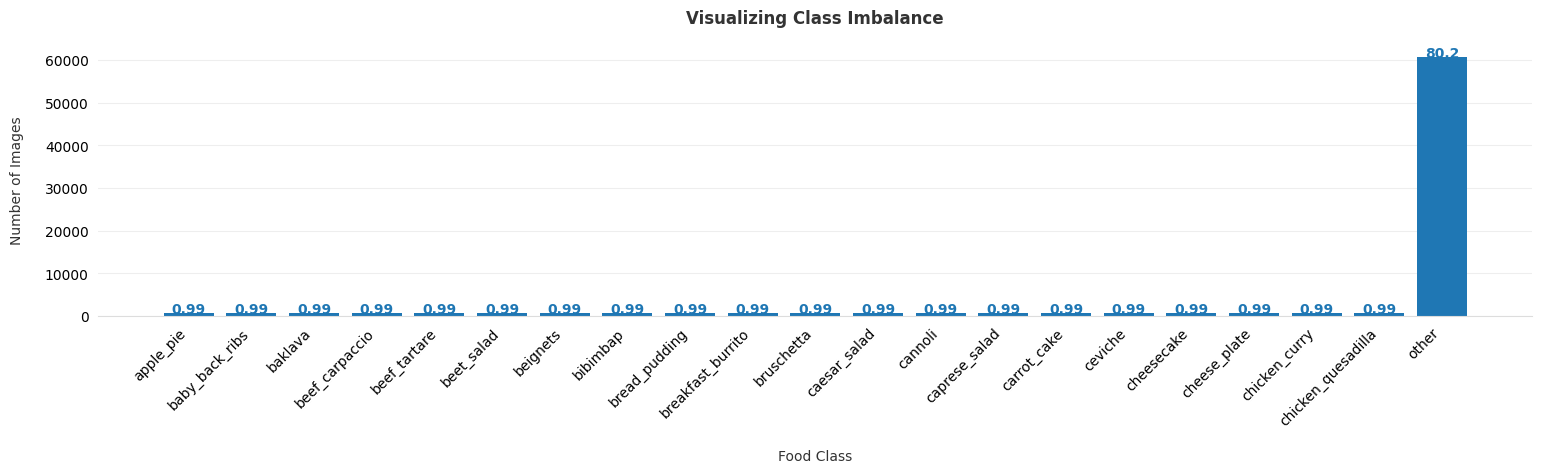

In [16]:
barplot_vis(train_imgs)

## Solving the imbalance problem
In the midterm project a pretrained model was used to ensure that the data set works as intended, the solution is to freeze the bottom layers and add one layer at the top that only trains to have 21 output values

# Preparing the Data For Modelling

In [17]:
# Data augmentation for training
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       torchvision.transforms.AutoAugment(torchvision.transforms.AutoAugmentPolicy.IMAGENET),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])
# Data augmentation for testing
test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

## Creation of a DataLoader for the Dataset

In [36]:
class Food21(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return self.dataframe.shape[0]

    def __getitem__(self, idx):
        img_name = self.dataframe.path.iloc[idx]
        image = Image.open(img_name)
        if image.mode != 'RGB':
            image = image.convert('RGB')
        label = encoder_21.get_idx(self.dataframe.label.iloc[idx])

        if self.transform:
            image = self.transform(image)

        return image, label

In [37]:
train_dataset = Food21(train_imgs, transform=train_transforms)
test_dataset = Food21(test_imgs, transform=test_transforms)

In [40]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=32)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=32)

In [41]:
# Testing the retrieval of a sample of images
for i in range(10):
    image = train_dataset.__getitem__(i)
    print(encoder_21.get_label(image[1]), image[0].shape)

other torch.Size([3, 224, 224])

other torch.Size([3, 224, 224])

chicken_curry torch.Size([3, 224, 224])

bibimbap torch.Size([3, 224, 224])

other torch.Size([3, 224, 224])

other torch.Size([3, 224, 224])

other torch.Size([3, 224, 224])

other torch.Size([3, 224, 224])

other torch.Size([3, 224, 224])

other torch.Size([3, 224, 224])


# Creating the ML Model

In [42]:
class Head(nn.Module):
    def __init__(self):
        super(Head, self).__init__()

        self.fc = nn.Linear(101, 21)
    
    def forward(self, x):
        return self.fc(x)

In [43]:
weights = models.DenseNet201_Weights.IMAGENET1K_V1
head = Head()

model = models.densenet201(weights = weights)

In [44]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

In [45]:
# Downloading updated pretrained weights 
import requests as reqs

url = "https://github.com/Prakhar998/Food-Classification/raw/master/food_classifier.pt"  
r = reqs.get(url, allow_redirects=True)

open("./food_classifier.pt", "wb").write(r.content)

81841763

In [46]:
checkpoint_path = "./food_classifier.pt"
classifier = nn.Sequential(
    nn.Linear(1920,1024),
    nn.LeakyReLU(),
    nn.Linear(1024,101),
)

model.classifier = classifier
model.load_state_dict(torch.load(checkpoint_path,map_location='cpu'),strict=False)

<All keys matched successfully>

In [47]:
model = nn.DataParallel(nn.Sequential(model, head))

torchinfo.summary(model, (1, 3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
DataParallel                                       [1, 21]                   --
├─Sequential: 1-1                                  [1, 21]                   20,165,699
├─Sequential: 1-2                                  --                        --
│    └─DenseNet: 2-1                               [1, 101]                  20,163,557
│    └─DenseNet: 2-2                               --                        --
│    │    └─Sequential: 3-1                        [1, 1920, 7, 7]           (18,092,928)
│    │    └─Sequential: 3-2                        --                        (18,092,928)
│    │    └─Sequential: 3-3                        [1, 101]                  2,070,629
│    │    └─Sequential: 3-4                        --                        2,070,629
│    └─Head: 2-3                                   [1, 21]                   2,142
│    └─Head: 2-4                                   --         

In [48]:
#hyper parameters
num_epochs = 10
lr = 1e-3

In [49]:
# loss
loss_fn = nn.CrossEntropyLoss()

# all parameters are being optimized
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=[0.9, 0.999])

# Training and Testing The Model

## Training the Model

In [50]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  print("--> Training Progress")
  # Loop through data loader data batches
  for batch, (X, y) in enumerate(tqdm(dataloader)):
      # Send data to target device
      images, labels = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(images)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, labels)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == labels).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [51]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      print("--> Testing Progress")
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(tqdm(dataloader)):
          # Send data to target device
          images, labels = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(images)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, labels)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)

          test_acc += ((test_pred_labels == labels).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc


In [58]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device,
          history: dict()):
  
  # Create empty results dictionairy if the provided dictionairy is empty
  if history == None:
      history = {
          "train_loss": [],
          "train_acc": [],
          "test_loss": [],
          "test_acc": [],
          'best train acc': (0, 0),
          "best_model": dict()
      }

  # Loop through training and testing steps for a number of epochs
  for epoch in range(epochs):
      print('Epoch {}/{}'.format(epoch + 1, epochs))

      train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
      test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

      # Print out what's happening
      print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
          f"\n\n=============================\n"
      )

      # Update results dictionary
      history["train_loss"].append(train_loss)
      history["train_acc"].append(train_acc)
      history["test_loss"].append(test_loss)
      history["test_acc"].append(test_acc)
      if test_acc > max(history["test_acc"]):
          history["best_model"] = model.state_dict()

      if test_acc > 0.96:
         break

  # Return the filled results at the end of the epochs
  return model, history

In [53]:
model, history = train(model, train_loader, test_loader, optimizer, loss_fn, num_epochs, device, history=None)

Epoch 1/10

--> Training Progress


100%|██████████| 592/592 [03:57<00:00,  2.50it/s]


--> Testing Progress


100%|██████████| 198/198 [01:09<00:00,  2.84it/s]


Epoch: 1 | train_loss: 0.5833 | train_acc: 0.8590 | test_loss: 0.1926 | test_acc: 0.9365






Epoch 2/10

--> Training Progress


100%|██████████| 592/592 [04:00<00:00,  2.47it/s]


--> Testing Progress


100%|██████████| 198/198 [01:10<00:00,  2.81it/s]


Epoch: 2 | train_loss: 0.4073 | train_acc: 0.8872 | test_loss: 0.1684 | test_acc: 0.9445






Epoch 3/10

--> Training Progress


100%|██████████| 592/592 [04:00<00:00,  2.46it/s]


--> Testing Progress


100%|██████████| 198/198 [01:10<00:00,  2.81it/s]


Epoch: 3 | train_loss: 0.3873 | train_acc: 0.8914 | test_loss: 0.1587 | test_acc: 0.9484






Epoch 4/10

--> Training Progress


100%|██████████| 592/592 [03:59<00:00,  2.47it/s]


--> Testing Progress


100%|██████████| 198/198 [01:10<00:00,  2.82it/s]


Epoch: 4 | train_loss: 0.3801 | train_acc: 0.8919 | test_loss: 0.1731 | test_acc: 0.9441






Epoch 5/10

--> Training Progress


100%|██████████| 592/592 [04:00<00:00,  2.46it/s]


--> Testing Progress


100%|██████████| 198/198 [01:10<00:00,  2.81it/s]


Epoch: 5 | train_loss: 0.3736 | train_acc: 0.8945 | test_loss: 0.1485 | test_acc: 0.9525






Epoch 6/10

--> Training Progress


100%|██████████| 592/592 [04:00<00:00,  2.46it/s]


--> Testing Progress


100%|██████████| 198/198 [01:10<00:00,  2.82it/s]


Epoch: 6 | train_loss: 0.3706 | train_acc: 0.8968 | test_loss: 0.1395 | test_acc: 0.9553






Epoch 7/10

--> Training Progress


100%|██████████| 592/592 [04:00<00:00,  2.46it/s]


--> Testing Progress


100%|██████████| 198/198 [01:10<00:00,  2.83it/s]


Epoch: 7 | train_loss: 0.3611 | train_acc: 0.8979 | test_loss: 0.1370 | test_acc: 0.9548






Epoch 8/10

--> Training Progress


100%|██████████| 592/592 [04:00<00:00,  2.46it/s]


--> Testing Progress


100%|██████████| 198/198 [01:10<00:00,  2.81it/s]


Epoch: 8 | train_loss: 0.3589 | train_acc: 0.8977 | test_loss: 0.1410 | test_acc: 0.9532






Epoch 9/10

--> Training Progress


100%|██████████| 592/592 [04:00<00:00,  2.46it/s]


--> Testing Progress


100%|██████████| 198/198 [01:10<00:00,  2.81it/s]


Epoch: 9 | train_loss: 0.3560 | train_acc: 0.8994 | test_loss: 0.1477 | test_acc: 0.9527






Epoch 10/10

--> Training Progress


100%|██████████| 592/592 [04:01<00:00,  2.45it/s]


--> Testing Progress


100%|██████████| 198/198 [01:10<00:00,  2.81it/s]

Epoch: 10 | train_loss: 0.3508 | train_acc: 0.9002 | test_loss: 0.1442 | test_acc: 0.9537







In [59]:
model, history = train(model, train_loader, test_loader, optimizer, loss_fn, epochs=5, device=device, history=history)

Epoch 1/5

--> Training Progress


100%|██████████| 592/592 [03:58<00:00,  2.49it/s]


--> Testing Progress


100%|██████████| 198/198 [01:09<00:00,  2.83it/s]


Epoch: 1 | train_loss: 0.3446 | train_acc: 0.9018 | test_loss: 0.1376 | test_acc: 0.9551






Epoch 2/5

--> Training Progress


100%|██████████| 592/592 [03:58<00:00,  2.48it/s]


--> Testing Progress


100%|██████████| 198/198 [01:10<00:00,  2.82it/s]


Epoch: 2 | train_loss: 0.3456 | train_acc: 0.9011 | test_loss: 0.1373 | test_acc: 0.9542






Epoch 3/5

--> Training Progress


100%|██████████| 592/592 [03:58<00:00,  2.48it/s]


--> Testing Progress


100%|██████████| 198/198 [01:10<00:00,  2.82it/s]


Epoch: 3 | train_loss: 0.3380 | train_acc: 0.9034 | test_loss: 0.1338 | test_acc: 0.9564






Epoch 4/5

--> Training Progress


100%|██████████| 592/592 [03:58<00:00,  2.48it/s]


--> Testing Progress


100%|██████████| 198/198 [01:09<00:00,  2.84it/s]


Epoch: 4 | train_loss: 0.3373 | train_acc: 0.9036 | test_loss: 0.1348 | test_acc: 0.9560






Epoch 5/5

--> Training Progress


100%|██████████| 592/592 [03:59<00:00,  2.48it/s]


--> Testing Progress


100%|██████████| 198/198 [01:09<00:00,  2.84it/s]

Epoch: 5 | train_loss: 0.3370 | train_acc: 0.9042 | test_loss: 0.1406 | test_acc: 0.9540







In [60]:
model, history = train(model, train_loader, test_loader, optimizer, loss_fn, epochs=5, device=device, history=history)

Epoch 1/5

--> Training Progress


100%|██████████| 592/592 [03:58<00:00,  2.48it/s]


--> Testing Progress


100%|██████████| 198/198 [01:10<00:00,  2.82it/s]


Epoch: 1 | train_loss: 0.3355 | train_acc: 0.9041 | test_loss: 0.1393 | test_acc: 0.9551






Epoch 2/5

--> Training Progress


100%|██████████| 592/592 [03:58<00:00,  2.48it/s]


--> Testing Progress


100%|██████████| 198/198 [01:09<00:00,  2.84it/s]


Epoch: 2 | train_loss: 0.3348 | train_acc: 0.9044 | test_loss: 0.1415 | test_acc: 0.9557






Epoch 3/5

--> Training Progress


100%|██████████| 592/592 [03:59<00:00,  2.48it/s]


--> Testing Progress


100%|██████████| 198/198 [01:09<00:00,  2.84it/s]

Epoch: 3 | train_loss: 0.3324 | train_acc: 0.9051 | test_loss: 0.1262 | test_acc: 0.9601







In [68]:
model, history = train(model, train_loader, test_loader, optimizer, loss_fn, epochs=3, device=device, history=history)

Epoch 1/3

--> Training Progress


100%|██████████| 592/592 [03:59<00:00,  2.47it/s]


--> Testing Progress


100%|██████████| 198/198 [01:09<00:00,  2.83it/s]


Epoch: 1 | train_loss: 0.3293 | train_acc: 0.9062 | test_loss: 0.1403 | test_acc: 0.9562






Epoch 2/3

--> Training Progress


100%|██████████| 592/592 [03:59<00:00,  2.47it/s]


--> Testing Progress


100%|██████████| 198/198 [01:09<00:00,  2.83it/s]


Epoch: 2 | train_loss: 0.3311 | train_acc: 0.9059 | test_loss: 0.1333 | test_acc: 0.9574






Epoch 3/3

--> Training Progress


100%|██████████| 592/592 [03:59<00:00,  2.47it/s]


--> Testing Progress


100%|██████████| 198/198 [01:10<00:00,  2.82it/s]

Epoch: 3 | train_loss: 0.3269 | train_acc: 0.9067 | test_loss: 0.1318 | test_acc: 0.9582







In [69]:
model, history = train(model, train_loader, test_loader, optimizer, loss_fn, epochs=1, device=device, history=history)

Epoch 1/1

--> Training Progress


100%|██████████| 592/592 [03:58<00:00,  2.48it/s]


--> Testing Progress


100%|██████████| 198/198 [01:10<00:00,  2.82it/s]

Epoch: 1 | train_loss: 0.3243 | train_acc: 0.9061 | test_loss: 0.1209 | test_acc: 0.9618







## Viewing the Learning History

In [70]:
def plot_history(history):

    loss = history['train_loss']
    accuracy = history['train_acc']
    val_loss = history['test_loss']
    val_accuracy = history['test_acc']
    x = range(len(loss))

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, accuracy, label='Training acc', color='#03045e', linewidth=2)
    if len(val_loss) != 0:
      plt.plot(x, val_accuracy, label='Validation acc', color='#48cae4', linewidth=2)
    plt.plot(history['best train acc'][0],
             history['best train acc'][1],
             label='Best train acc', markersize=7, color='black')
    plt.title('Accuracy')
    plt.grid(True)
    plt.legend()


    plt.subplot(1, 2, 2)
    plt.plot(x, loss, label='Training loss', color='#03045e', linewidth=2)
    if len(val_loss) != 0:
      plt.plot(x, val_loss, label='Validation loss', color='#48cae4', linewidth=2)
    plt.title('Loss')
    plt.grid(True)
    plt.legend()

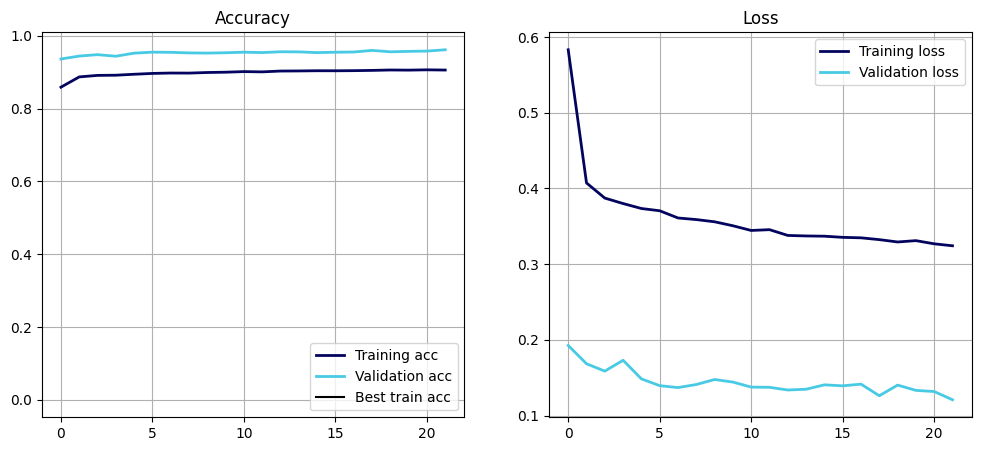

In [71]:
plot_history(history)

# Assessing The Results

## Getting the Accuracy

In [72]:
def evaluate(model, dataloader):

  random = np.random.randint(0, len(dataloader))

  with torch.no_grad():
    model.eval()
    n_correct = 0
    n_samples = 0

    for images, labels in tqdm(dataloader):
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)

      preds = torch.argmax(torch.softmax(outputs, 1), 1)

      n_samples += labels.shape[0]
      n_correct += (preds==labels).sum().item()

    acc = 100.0 * n_correct / n_samples
    print(acc)

In [73]:
evaluate(model,test_loader)

100%|██████████| 198/198 [01:11<00:00,  2.77it/s]

96.16633663366336


## Assessing the Results Visually

In [77]:
def visually_evaluate(model, data_df):
    num_rows = 3
    num_cols = 6

    random_idx = np.random.randint(0, data_df.shape[0], num_rows*num_cols)

    # Retrieve a number of images from the dataset.
    imgs, labels = data_df.iloc[random_idx], data_df.iloc[random_idx].label
    eval_dataset = Food21(imgs, transform=test_transforms)
    eval_loader = DataLoader(eval_dataset, batch_size=num_rows*num_cols, shuffle=False)
    eval_set = next(iter(eval_loader))

    # Get predictions from model.
    model.eval()
    preds = model(eval_set[0].to(device))
    preds = torch.argmax(torch.softmax(preds, dim=1), dim=1)

    str_preds = []
    for idx in range(len(preds)):
        str_preds.append( encoder_21.get_label(preds[idx]) )
        
    plt.figure(figsize=(20, 8))

    num_matches = 0
    for idx in range(num_rows*num_cols):
        ax = plt.subplot(num_rows, num_cols, idx + 1)
        plt.axis("off")

        img = plt.imread(imgs.path.iloc[idx])
        plt.imshow(img)

        title = str(labels.iloc[idx]) + " : " + str_preds[idx]
        title_obj = plt.title(title, fontdict={'fontsize':13})

        if labels.iloc[idx] == str_preds[idx]:
            num_matches += 1
            plt.setp(title_obj, color='g')
        else:
            plt.setp(title_obj, color='r')

        acc = num_matches/(idx+1)
    print("Prediction accuracy on test images: ", int(100*acc)/100)

    return

Prediction accuracy on test images:  1.0


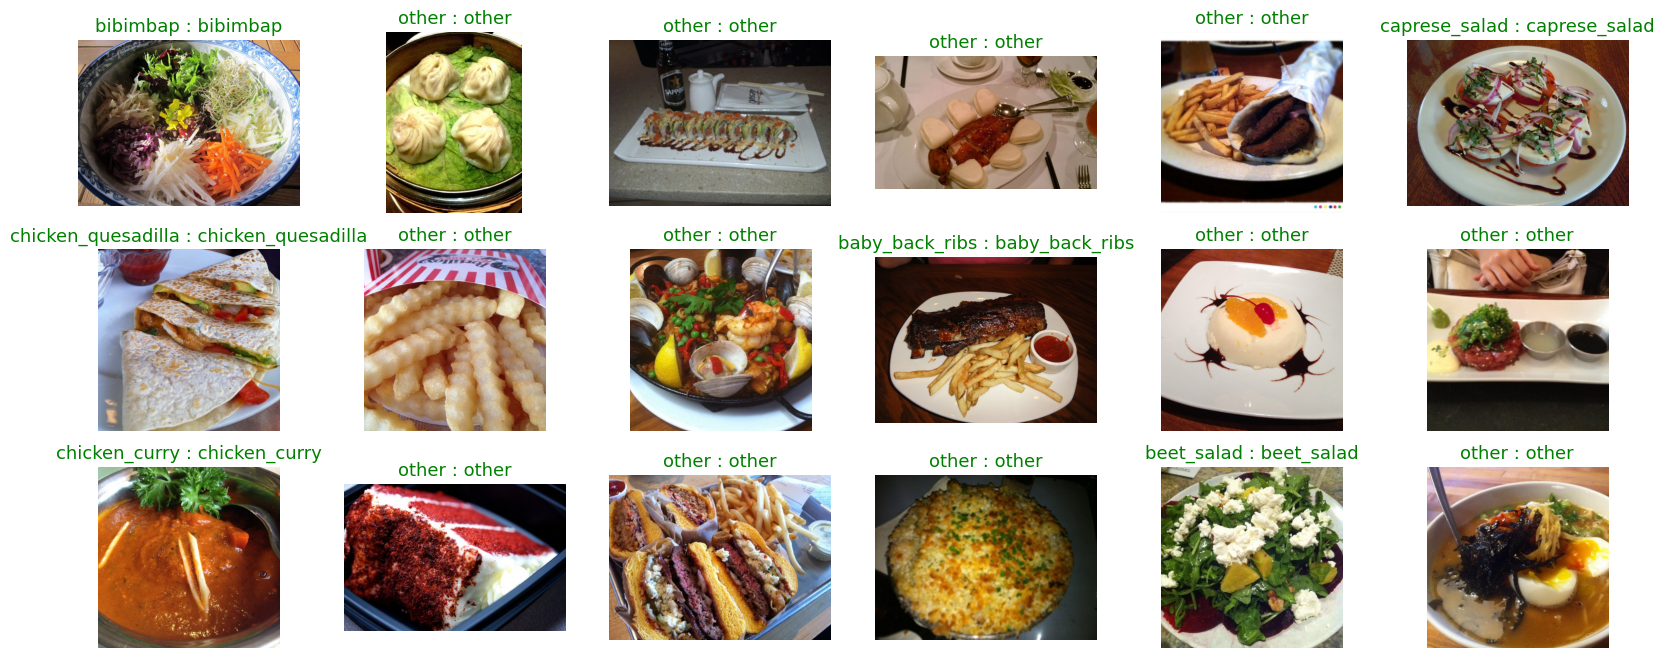

In [78]:
visually_evaluate(model, test_imgs)

# Saving the Model Results

In [89]:
torch.save(model.state_dict(), "./midterm_project_solution_final_state.pth")